<img src="lab_logo.png">

# iPython script for the Multi-Chromatic Stimulator Project
by MJY Zimmermann & P Bartel

Baden Lab, CRPC, School of Life Sciences, University of Sussex, United Kingdom

***

##### Source : https://github.com/BadenLab/Multi-Chromatic-Stmulator

##### This project is Open Source licensed, released under CERN OHL v1.2 

***

This script calculates opsin spectra as described in [Govardovskii et al.](https://www.cambridge.org/core/journals/visual-neuroscience/article/in-search-of-the-visual-pigment-template/A4738E821720092B7F5A233C4AB4962B) (In search of the visual pigment template, 2000).

It then allows the estimation of photoceptor excitation caused by LED light sources used in the stimulator. To this end, we used a compact CCD Spectrometer (CCS200/M, Thorlabs, Germany) in combination with the Thorlabs Optical Spectrum Analyzers (OSA) software and coupled to a linear fibre patch cable and an optical energy power (PM100D, Thorlabs, Germany) in combination with the Thorlabs Optical Power Monitor (OPM) software and coupled to a photodiode power sensor (S130VC, Thorlabs, Germany). 

*__Note:__ This script is used for the tetrachromatic (zebrafish) version of the visual stimulator; it can be easily adapted to other animals with more spectral sensitivites and light source/filter combinations.*

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib.pyplot import figure
%matplotlib inline
import seaborn as sns
import scipy as scipy
from scipy.optimize import curve_fit
from scipy import stats, integrate
from scipy.optimize import minimize
from scipy.signal import savgol_filter as savgol
from IPython.display import Image,HTML,display

***

## Setting global parameters
Here we defined the max absorbance for each cone opsin present in the Zebrafish. The following values are taken from 
[Allison et al](https://www.cambridge.org/core/journals/visual-neuroscience/article/visual-pigment-composition-in-zebrafish-evidence-for-a-rhodopsinporphyropsin-interchange-system/D7824490079257A101123EBD593C153C) (Visual pigment composition in zebrafish: Evidence for a rhodopsin–porphyropsin interchange system, 2004)

In [2]:
PeakWavelength = [565, 482, 411, 361]                   # Peak opsin absorbance wavelengths in nm (R,G,B,UV)
nCone = len(PeakWavelength)                             # Number of LED (4 in our tested stimulator)
nLED = 4                                                # Number of cones in the considered animal model

spectrumPath = ".//Spectrometer_Recording//Spectrum//"  # Set path to Spectrometer recording folder
powerPath = ".//Powermeter_Recording//"                 # Set path to Powermeter recording folder  
filterpath = ".//Filters//"                            # Set path to optical filters spectra

#### Figure Parameters

In [3]:
SpectraRange = (300,700)                   # Spectrum Range in nm displayed on the various graph 
FigureSize = (15,10)                       # Set the size of all spectra figures
FigureFontSize = 20                        # Set the font size for spectra figure labels
FigureTitleSize = 25                       # Set the font size for spectra figure titles

colour = ['r','g','b','m']                 # Set colour array for traces
colors = ["#ff471a",'#39e600','#3399ff','#ff80ff']
Colour = ['r--','g--','b--','m--']         # Set colour array for traces
colourmap = 'seismic'
Colourmap = 'gnuplot'
RGBA = [(0.8,0,0,0.3),(0,0.8,0,0.3),(0,0,0.8,0.3),(0.4,0,0.4,0.3)]

plt.style.use('dark_background')           # Set ploting style

PMT1_min = 520                             # PMT 1 bandpass filter low wavelength (nm)
PMT1_max = 550                             # PMT 1 bandpass filter high wavelength (nm)
PMT2_min = 615                             # PMT 2 bandpass filter low wavelength (nm)
PMT2_max = 645                             # PMT 2 bandpass filter high wavelength (nm)

#### Define a normalisation function

In [4]:
def normalise (myarray):
    myarray = myarray/np.nanmax(np.abs(myarray))
    return myarray

#### Set a "rainbow" gradient that attributes a given wavelentgh (in nm) to its approximate RGB color value
This part of the code is taken from http://www.noah.org/wiki/Wavelength_to_RGB_in_Python.

Based on Dan Bruton's code: http://www.physics.sfasu.edu/astro/color/spectra.html

C:\Users\Maxime\Anaconda3\lib\site-packages\matplotlib\figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


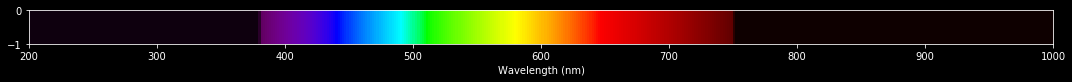

In [5]:
def wavelength_to_rgb(wavelength, gamma=0.8):
    wavelength = float(wavelength)
    if wavelength >= 380 and wavelength <= 750:
        A = 1.
    else:
        A=0.15
    if wavelength < 380:
        wavelength = 380.
    if wavelength >750:
        wavelength = 750.
    if wavelength >= 380 and wavelength <= 440:
        attenuation = 0.3 + 0.7 * (wavelength - 380) / (440 - 380)
        R = ((-(wavelength - 440) / (440 - 380)) * attenuation) ** gamma
        G = 0.0
        B = (1.0 * attenuation) ** gamma
    elif wavelength >= 440 and wavelength <= 490:
        R = 0.0
        G = ((wavelength - 440) / (490 - 440)) ** gamma
        B = 1.0
    elif wavelength >= 490 and wavelength <= 510:
        R = 0.0
        G = 1.0
        B = (-(wavelength - 510) / (510 - 490)) ** gamma
    elif wavelength >= 510 and wavelength <= 580:
        R = ((wavelength - 510) / (580 - 510)) ** gamma
        G = 1.0
        B = 0.0
    elif wavelength >= 580 and wavelength <= 645:
        R = 1.0
        G = (-(wavelength - 645) / (645 - 580)) ** gamma
        B = 0.0
    elif wavelength >= 645 and wavelength <= 750:
        attenuation = 0.3 + 0.7 * (750 - wavelength) / (750 - 645)
        R = (1.0 * attenuation) ** gamma
        G = 0.0
        B = 0.0
    else:
        R = 0.0
        G = 0.0
        B = 0.0
    return (R,G,B,A)

clim=(350,780)
norm = plt.Normalize(*clim)
wl = np.arange(clim[0],clim[1]+1,2)
colorlist = list(zip(norm(wl),[wavelength_to_rgb(w) for w in wl]))
spectralmap = matplotlib.colors.LinearSegmentedColormap.from_list("spectrum", colorlist)

fig, axs = plt.subplots(1, 1, figsize=(15,1.25), tight_layout=True)

wavelengths = np.linspace(200, 1000, 1000)
spectrum = (5 + np.sin(wavelengths*0.1)**2) * np.exp(-0.00002*(wavelengths-600)**2)

y = np.linspace(0, -1, 100)
X,Y = np.meshgrid(wavelengths, y)

extent=(np.min(wavelengths), np.max(wavelengths), np.min(y), np.max(y))

plt.imshow(X, clim=clim,  extent=extent, cmap=spectralmap, aspect='auto')
plt.xlabel('Wavelength (nm)')
plt.ylim(-1,0)
plt.fill_between(wavelengths, spectrum,  8, color='w');

#### Generate heatmap template for display purposes

In [6]:
def heatmap(data, row_labels, col_labels, ax=None, cbar_kw={}, cbarlabel="", **kwargs):

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels,fontsize=FigureFontSize)
    ax.set_yticklabels(row_labels,fontsize=FigureFontSize)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=False, bottom=True, left = True,
                   labeltop=False, labelbottom=True)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=30, ha="right",rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="white", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",textcolors=["white", "black"],threshold=None, **textkw):

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[im.norm(data[i, j]) > threshold])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

***

***

## Extract Spectrometer Recording to obtain LED spectra profile 
To determine the LEDs spectra, we used a compact CCD Spectrometer (CCS200/M, Thorlabs, Germany) in combination with the Thorlabs Optical Spectrum Analyzers (OSA) software and coupled to a linear fibre patch cable.

The following script is configured by default for ThorLab Spectrometer recording in .csv format. If a different spectrometer is used, the general parameters below need to be modified.

Here the calibration sequence was used (link). LED are successively played from 0 to 100

In [7]:
nLoops = 5                           # Number of recording loop (5 in the submitted example)
nPoints = 100                        # Number of recording point per LED (100 in the current example (from 1 to 100% light intensity with an increment of 1))
SpectraNumber = nLoops*nLED*nPoints  # Total recording point number
ExcludePoints = 7                    # Number of point to discard at the end of recording
FirstPoint = 33                      # Start of the recording point in the csv file (33 in the submitted example)
SpectraStart = 19                    # First recording point (in our example: Spectrum000000019)
lenSpectra = 9                       # Length of the file string number (9 for ThorLab Spectrometer)

Spectra = []
for j in range(0,SpectraNumber):
    FileNumber = str(SpectraStart+j)
    FileNumber = FileNumber.rjust(lenSpectra,'0')
    FileName = spectrumPath + 'Spectrum' + FileNumber + '.csv'
    a = np.asarray(pd.read_csv(FileName))[FirstPoint:-1,:].reshape(-1)
    a2 = np.asarray([a[i][17:] for i in range(a.shape[0])]).astype(float)
    Spectra.append(a2)
    
Spectra = np.asarray(Spectra)
WvsX = np.asarray([a[i][:16] for i in range(a.shape[0])]).astype(float)
Spectra=Spectra.reshape(nLoops,nLED*nPoints,-1)
Spectra = np.mean(Spectra,axis = 0)


# Generate Opsin Template
This code fits Govardovskii (A1) templates to desired peak wavelengths: lambdamax - [Govardovskii et al.](https://www.cambridge.org/core/journals/visual-neuroscience/article/in-search-of-the-visual-pigment-template/A4738E821720092B7F5A233C4AB4962B) (In search of the visual pigment template, 2000). Itself adapted from the template described by [Lamb et al](https://www.sciencedirect.com/science/article/pii/004269899500114F?via%3Dihub) (Photoreceptor Spectral Sensitivities:Common Shape in the Long-wavelength Region)

***

#### AlphaBand     $$S\alpha(x) = \frac{1}{exp[A(a-x)] + exp[B(b-x)] + exp[C(c-x)] + D}$$

Where $x$ = $\frac{\lambda max}{\lambda}$

With $a$ the only variable parameter such as $a$ = $0.8795 + 0.0459 * exp^{\frac{(\lambda max -300)^{2}}{11940}}$, and constant parameters (A, B, b, C, c, D) as defined below.

***

#### BetaBand      $$S\beta(\lambda) = A\beta * exp^{-(\frac{\lambda - \lambda m\beta}{b})^{2}}$$

With $A\beta$  the amplitude of the $\beta band$ relative to the $\alpha band$, $\lambda m\beta$ the position of the $\beta peak$ and $b$ a bandwidth parameter


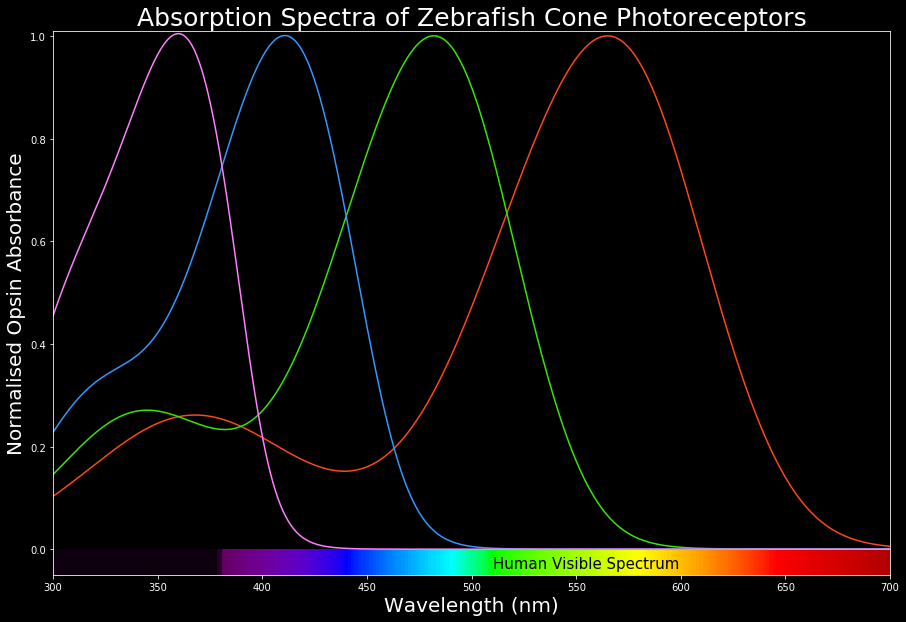

In [8]:
def Govardovskii (wvsloc, lambdamax):
   '''This function returns one sensitivity spectrum point y at wavelength = wvs of an opsin  with a peak at lambdamax, wvs - such wavelengths at which the template will be evaluated: 1d-array lambdamax - peak of the sensitivity spectrum'''
   wvs = np.asarray(wvsloc)

   ##### AlphaBand ######
   A = 69.7
   a = 0.8795+0.0459*np.exp(-np.square(lambdamax-300)/11940)
   B = 28
   b = 0.922
   C = -14.9
   c = 1.104
   D = 0.674
   x = lambdamax/wvs
   alphaband = 1/ (np.exp(A*(a-x))+np.exp(B*(b-x))+np.exp(C*(c-x))+D)
   
   ##### BetaBand ######
   Ab = 0.26 #Beta value at peak
   b = -40.5+0.195*lambdamax #Beta bandwidth
   Lamb = 189+0.315*lambdamax #Beta peak
   betaband = Ab * np.exp(-1*((wvs-Lamb)/b)**2)
   return alphaband+betaband


fig,ax = plt.subplots(1,1,figsize = FigureSize)

Opsin =[]

for i in range (nCone):
    opsin = Govardovskii(WvsX,PeakWavelength[i])
    Opsin.append(opsin)
    
    ax.plot(WvsX,Opsin[i],c=colors[i])
    

ax.set_title('Absorption Spectra of Zebrafish Cone Photoreceptors', fontsize = FigureTitleSize)
ax.set_xlabel('Wavelength (nm)', fontsize = FigureFontSize)
ax.set_ylabel('Normalised Opsin Absorbance', fontsize = FigureFontSize)

ax.imshow(X, clim=clim,  extent=extent, cmap=spectralmap, aspect = 'auto')
plt.text(510, -0.0375, 'Human Visible Spectrum', color="black", fontsize=15)

ax.set_xlim(SpectraRange)
ax.set_ylim(-0.05,1.01);

fig.savefig('Cone Absoprtion Spectra.png')

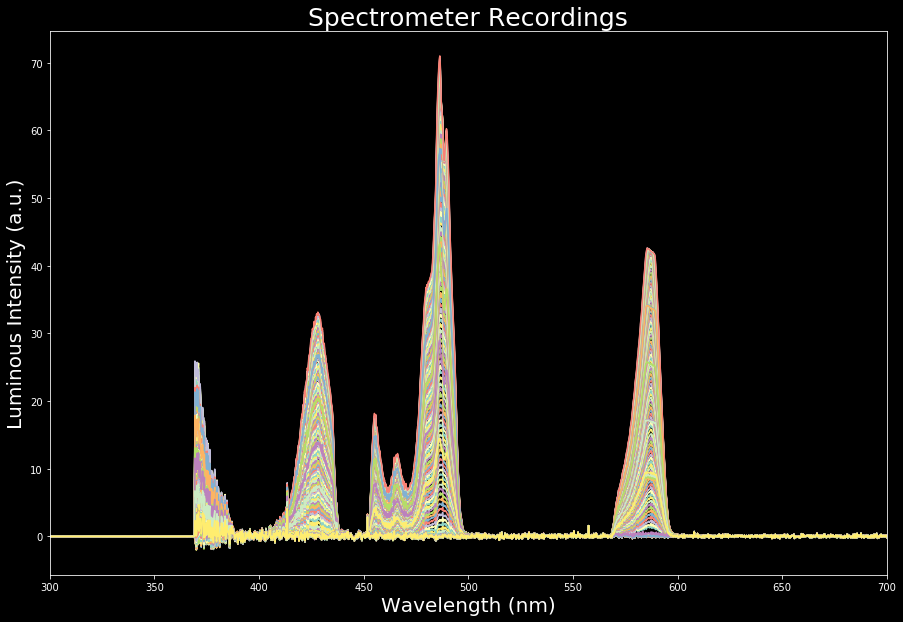

In [9]:
fig,ax = plt.subplots(1,1,figsize = FigureSize)
[ax.plot(WvsX,Spectra[i,:]) for i in range(nLED*nPoints)]

ax.set_title('Spectrometer Recordings', fontsize = FigureTitleSize)
ax.set_xlabel('Wavelength (nm)', fontsize = FigureFontSize)
ax.set_ylabel('Luminous Intensity (a.u.)', fontsize = FigureFontSize)
ax.set_xlim((SpectraRange));
fig.savefig('Spectrometer Recordings.png')

#### Use a Savitzky–Golay filter to smooth the recorded "Spectra" traces

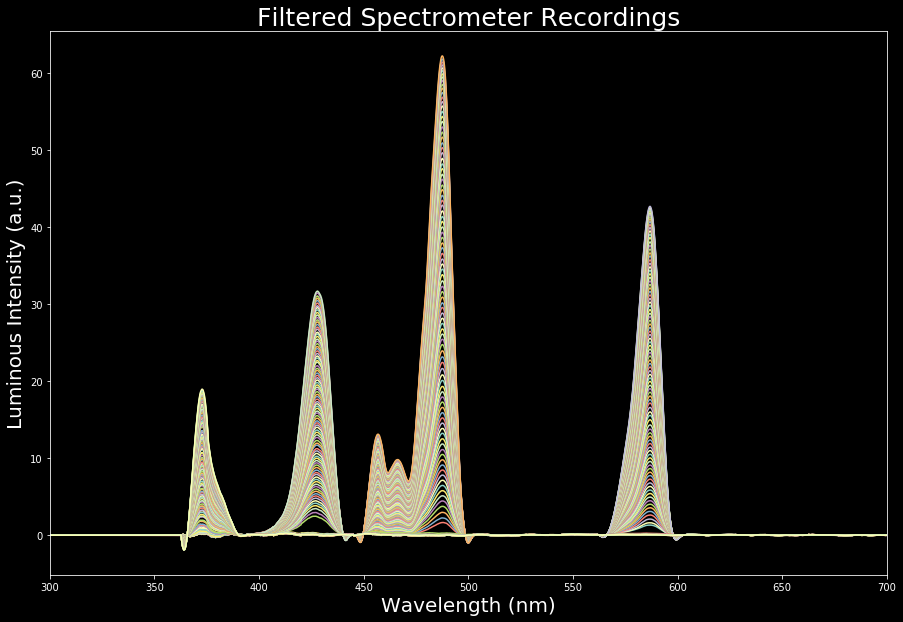

In [10]:
savgolWindow = 61   # The length of the filter window
savgolOrder = 2     # The order of the polynomial used to fit the samples.
savgolDelta = 1     # The spacing of the samples to which the filter will be applied.

Smoothed = savgol(Spectra, savgolWindow, savgolOrder, delta = savgolDelta, axis = -1)
Smoothed = Smoothed.reshape(nLED,nPoints,-1)
Smoothed = Smoothed[:,:-ExcludePoints,:]

fig,ax = plt.subplots(1,1,figsize = FigureSize)
[ax.plot(WvsX,Smoothed[0,i,:]) for i in range(Smoothed.shape[1])]
[ax.plot(WvsX,Smoothed[1,i,:]) for i in range(Smoothed.shape[1])]
[ax.plot(WvsX,Smoothed[2,i,:]) for i in range(Smoothed.shape[1])]
[ax.plot(WvsX,Smoothed[3,i,:]) for i in range(Smoothed.shape[1])]

ax.set_title('Filtered Spectrometer Recordings', fontsize = FigureTitleSize)
ax.set_xlabel('Wavelength (nm)', fontsize = FigureFontSize)
ax.set_ylabel('Luminous Intensity (a.u.)', fontsize = FigureFontSize)
ax.set_xlim((SpectraRange));
fig.savefig('Filtered Spectrometer Recordings.png')

#### Plot all normalised LED intensity value individually

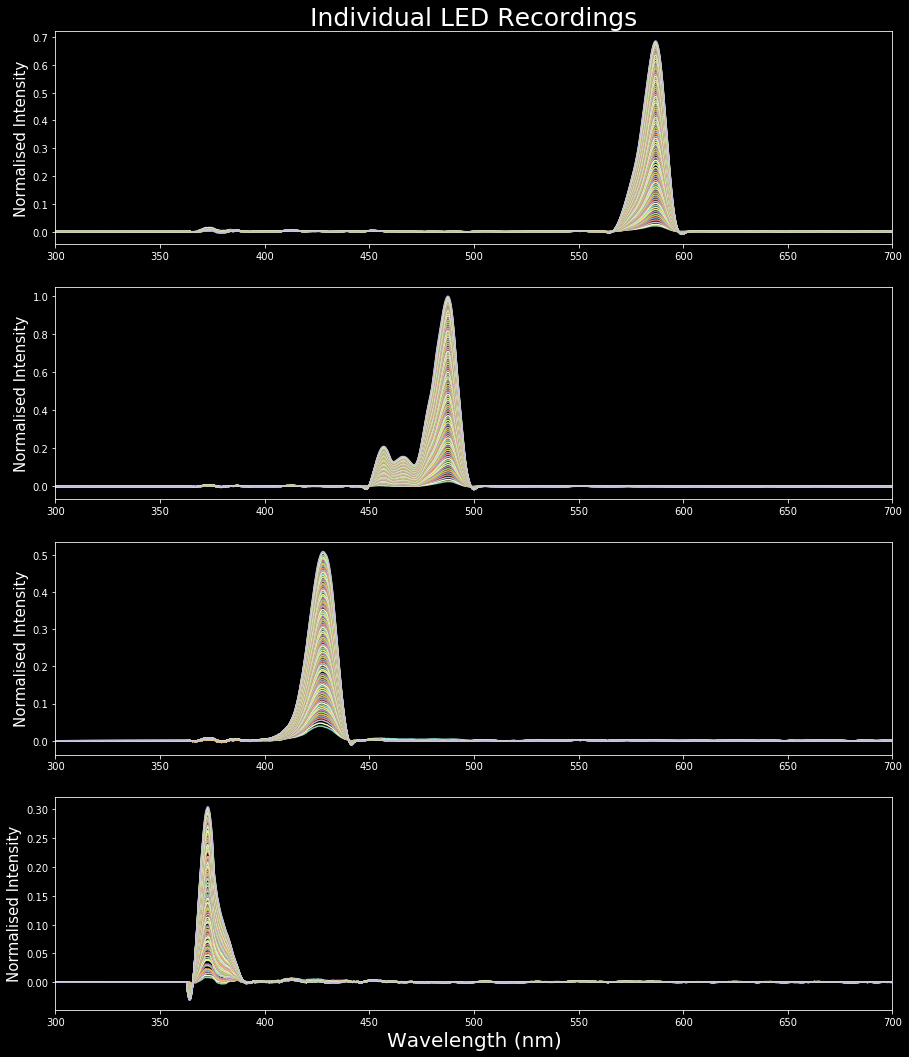

In [11]:
fig,ax = plt.subplots(4,1,figsize = (15,18))

Smoothed_norm = normalise(Smoothed)

[ax[0].plot(WvsX,Smoothed_norm[0,i,:]) for i in range(Smoothed.shape[1])];
[ax[1].plot(WvsX,Smoothed_norm[1,i,:]) for i in range(Smoothed.shape[1])];
[ax[2].plot(WvsX,Smoothed_norm[2,i,:]) for i in range(Smoothed.shape[1])];
[ax[3].plot(WvsX,Smoothed_norm[3,i,:]) for i in range(Smoothed.shape[1])];


[ax[0].set_title('Individual LED Recordings', fontsize = FigureTitleSize)]
[ax[i].set_xlabel('Wavelength (nm)', fontsize = FigureFontSize) for i in [3]]
[ax[i].set_ylabel('Normalised Intensity', fontsize = 15) for i in [0,1,2,3]]

[ax[i].set_xlim(SpectraRange) for i in [0,1,2,3]];

### Determine peak wavelength for each LED in nm

In [12]:
MaxesIndices = np.argmax(Smoothed[:,-1,:],axis = -1)

Peaks = WvsX[MaxesIndices]
Peaks = np.around(Peaks,decimals=1)

LEDS = ['Red','Green','Blue','UV'] 

[print (LEDS[i] + ' LED Peak Wavelength = ' + str(Peaks[i]) + 'nm') for i in range (nLED)];

Red LED Peak Wavelength = 586.9nm
Green LED Peak Wavelength = 487.5nm
Blue LED Peak Wavelength = 427.9nm
UV LED Peak Wavelength = 372.8nm


***

### Setting functions and parameters to establish LED performances

In [13]:
def linfunc(x,param):
    a,b = param
    return a+b*x

def linfunc_error(param,x,y):
    """x is current, param is a vector of length 2, y is all luminescence values"""
    y_pred = linfunc(x,param)
    return np.sum((y-y_pred)**2)/y.shape[0]


x0 = [1,1] # initial guess for a,b
Args = []
Solution = []
SSE = []

for i in range (nLED):
    args = (np.arange(1,nPoints-ExcludePoints+1),np.sum(Smoothed[i,:,:],axis=-1))
    Args.append(args)
    
    solution = minimize(linfunc_error, x0 = x0, args = Args[i]).x
    Solution.append(solution)
    
    sse = np.sqrt(linfunc_error(Solution[i], Args[i][0], Args[i][1]))
    sse = np.around(sse,decimals=2)
    SSE.append(sse)

#### Plot LEDs intensities (relative output power) against their forward current

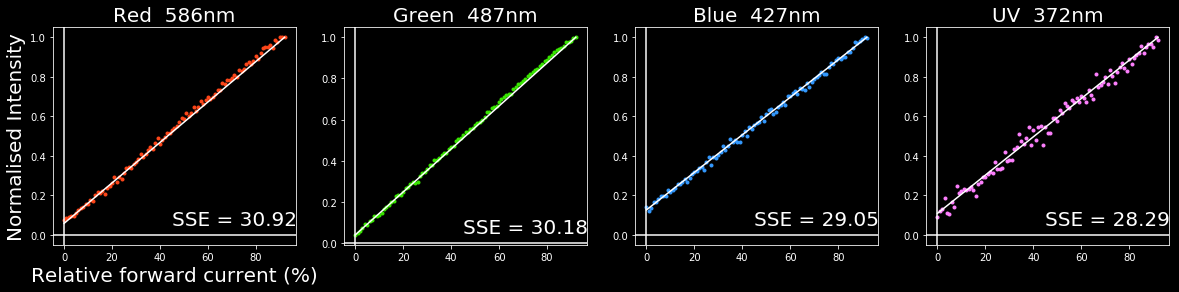

In [14]:
fig,ax = plt.subplots(1,nLED,figsize = (20,4))
titles = ['Red  '+str(int(Peaks[0]))+'nm','Green  '+str(int(Peaks[1]))+'nm','Blue  '+str(int(Peaks[2]))+'nm','UV  '+str(int(Peaks[3]))+'nm']

SSE_Font = 20
SSE_x = 45
SSE_y = 0.05

for i in range (nLED):
    ax[i].plot(normalise(np.sum(Smoothed[i,:,:],axis=-1)),'.',color = colors[i])
    
    ax[i].plot(normalise(linfunc(Args[i][0],Solution[i])),"k", color = 'white')
    ax[i].text(SSE_x,SSE_y,'SSE = '+str(SSE[i]),fontsize=SSE_Font)
    
    ax[i].axhline()
    ax[i].axvline()
    
    ax[i].set_title(titles[i], fontsize = FigureFontSize)
    
    ax[0].set_xlabel('Relative forward current (%)', fontsize = FigureFontSize)
    ax[0].set_ylabel('Normalised Intensity', fontsize = FigureFontSize)


fig.savefig('Normalised Intensity VS Forward Current.png')

### Plot LED spectra

In [15]:
Red_Filter = np.loadtxt(filterpath + "Filter_R.txt")
Green_Filter = np.loadtxt(filterpath + "Filter_G.txt")
Blue_Filter = np.loadtxt(filterpath + "Filter_B.txt")
UV_Filter = np.loadtxt(filterpath + "Filter_U.txt")
WvsY = np.linspace(300,1026,3159)

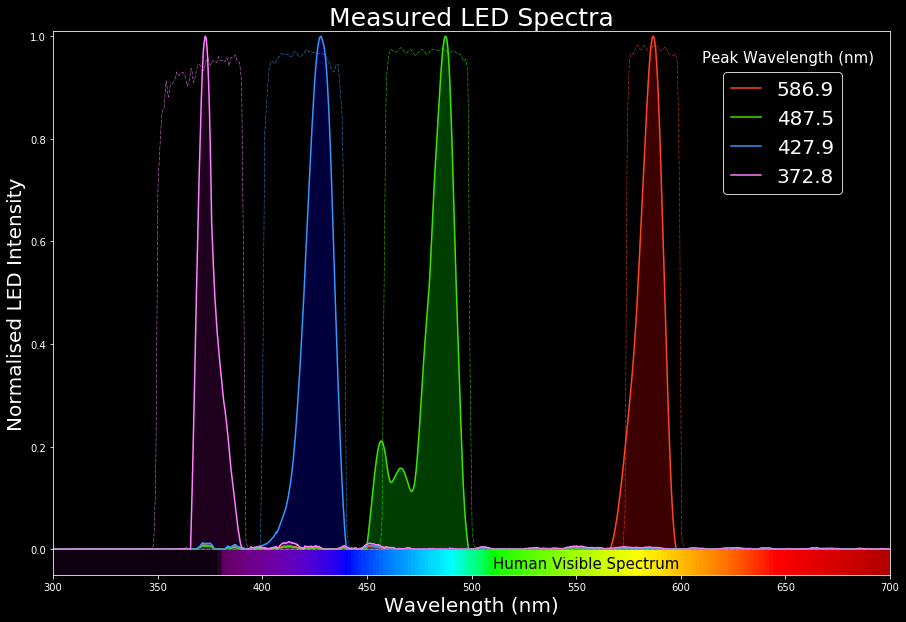

In [16]:
fig,ax = plt.subplots(1,1,figsize = FigureSize)

LEDNormalised = []
LEDnormalised = []

for i in range (nLED):

    LEDNorm = np.divide(Smoothed[i,nPoints-ExcludePoints-1,:],np.amax(Smoothed[i,nPoints-ExcludePoints-1,:]))
    LEDNormalised.append(LEDNorm)

    LEDnorm = np.copy(LEDNormalised[i])
    LEDnorm[LEDnorm<0] = 0
    LEDnormalised.append(LEDnorm)
    
    ax.plot(WvsX,LEDnormalised[i],colors[i])
    ax.fill(WvsX,LEDnormalised[i], c=RGBA[i])

ax.set_title('Measured LED Spectra', fontsize = FigureTitleSize)
ax.set_xlabel('Wavelength (nm)', fontsize = FigureFontSize)
ax.set_ylabel('Normalised LED Intensity', fontsize = FigureFontSize)

ax.imshow(X, clim=clim,  extent=extent, cmap=spectralmap, aspect = 'auto')
plt.text(510, -0.0375, 'Human Visible Spectrum', color='black', fontsize=15)

plt.plot(WvsY,Red_Filter,'-.',color=colors[0],linewidth=0.5)
plt.plot(WvsY,Green_Filter,'-.',color=colors[1],linewidth=0.5)
plt.plot(WvsY,Blue_Filter,'-.',color=colors[2],linewidth=0.5)
plt.plot(WvsY,UV_Filter,'-.',color=colors[3],linewidth=0.5)

plt.legend((Peaks[0], Peaks[1], Peaks[2], Peaks[3]), shadow=True, loc=(0.8, 0.7), handlelength=1.5, fontsize=20)
plt.text(610,0.95, 'Peak Wavelength (nm)', fontsize=15);

ax.set_xlim(SpectraRange)
ax.set_ylim(-0.05,1.01);

plt.savefig("Measured LED Spectra.png")

# Plot LED spectra against the zebrafish cone absorbance spectra. 
Graph includes the PMT detector bands

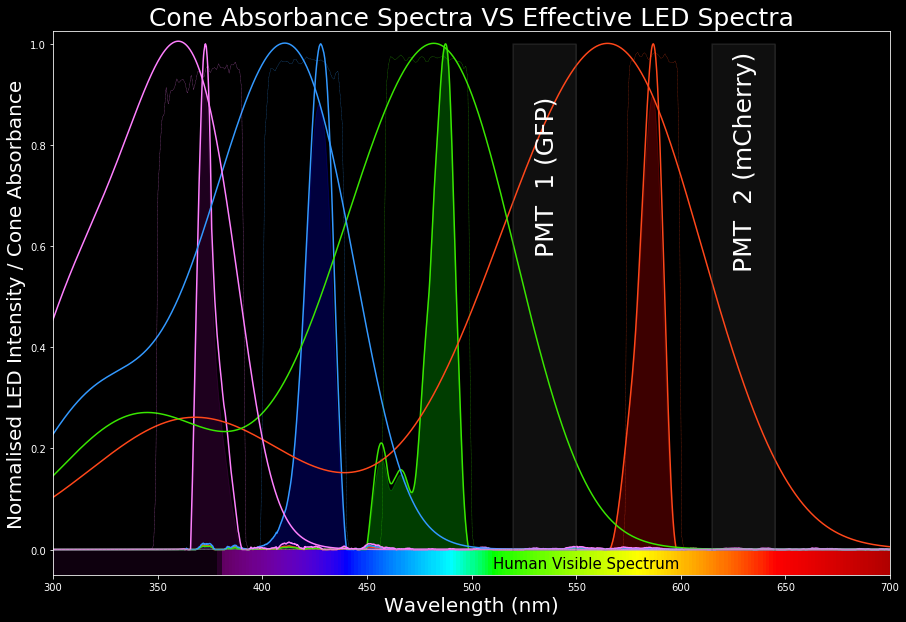

In [17]:
fig,ax = plt.subplots(1,1,figsize = FigureSize)

for i in range (nLED):
    ax.plot(WvsX, LEDnormalised[i], colors[i])
    ax.fill(WvsX, LEDnormalised[i]*Opsin[i], c=RGBA[i])
    
for i in range (nCone):
    ax.plot(WvsX, Opsin[i], colors[i])


ax.set_xlim(SpectraRange)
ax.set_ylim(-0.05,1.025)

plt.plot([PMT1_min,PMT1_min,PMT1_max,PMT1_max], [0,1,1,0], c = (0.3,0.3,0.3,0.3))
ax.fill([PMT1_min,PMT1_min,PMT1_max,PMT1_max], [0,1,1,0], c = (0.3,0.3,0.3,0.2))
plt.text(PMT1_min+10, 0.66+0.2, 'PMT  1 (GFP)', fontsize=25, rotation=90)

plt.plot([PMT2_min,PMT2_min,PMT2_max,PMT2_max], [0,1,1,0], c = (0.3,0.3,0.3,0.3))
ax.fill([PMT2_min,PMT2_min,PMT2_max,PMT2_max], [0,1,1,0], c = (0.3,0.3,0.3,0.2))
plt.text(PMT2_min+10, 0.749+0.2, 'PMT  2 (mCherry)', fontsize=25, rotation=90)

plt.plot(WvsY,Red_Filter,'--',color=colors[0],linewidth=0.25)
plt.plot(WvsY,Green_Filter,'--',color=colors[1],linewidth=0.25)
plt.plot(WvsY,Blue_Filter,'--',color=colors[2],linewidth=0.25)
plt.plot(WvsY,UV_Filter,'--',color=colors[3],linewidth=0.25)

ax.set_title('Cone Absorbance Spectra VS Effective LED Spectra', fontsize = FigureTitleSize)
plt.xlabel('Wavelength (nm)', fontsize = FigureFontSize)
plt.ylabel('Normalised LED Intensity / Cone Absorbance', fontsize = FigureFontSize)

ax.imshow(X, clim=clim,  extent=extent, cmap=spectralmap, aspect = 'auto')
plt.text(510, -0.0375, 'Human Visible Spectrum', color ='black', fontsize=15)

plt.savefig("Opsin-LED Spectra.png")

# Estimate relative co-excitation of photoreceptors by the LEDs

C:\Users\Maxime\Anaconda3\lib\site-packages\ipykernel_launcher.py:65: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


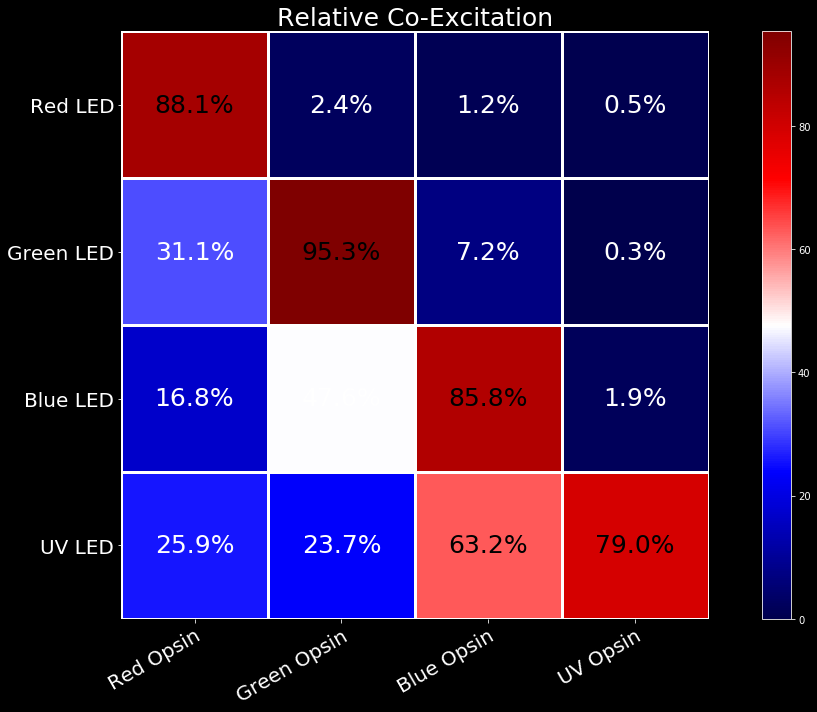

In [18]:
Ops = np.asarray(Opsin)
Ops = Ops.swapaxes(1,0)

led = np.asarray(LEDnormalised)
led = led.swapaxes(1,0)


M0 = np.zeros((nCone,nLED, len(led[:,0])))        # M0 is needed to take integrals over LED*OPS
M = np.zeros((nCone,nLED))                        # M1 is the M matrix of Estevez, gives vector of response changes (r) from vector of stimulus changes (s): r = M1*s
M1 = np.zeros((nCone,nLED))


for iCone in range(0,(nCone)):                    # For each cone...
    for iLED in range(0,(nLED)):                     # For each LED...
        M0[iCone,iLED,:] = Ops[:,iCone]*led[:,iLED]            # Multiply Ops and Led elements 
        M[iCone,iLED] = np.sum(M0[iCone,iLED,:])               # Generate a cross activation integral M = (Ops*Led)
        M1[iCone,iLED] = M[iCone,iLED]/np.sum(led[:,iLED])     # Divide the cross activation integral by the LED integral M1 = M/Led
        
# Display M matrix
M1_Matrix = M1*100
M1_Matrix = M1_Matrix.swapaxes(1,0)
vmx = np.amax(np.abs(M1_Matrix.reshape(-1)))
vmn = 0

Cones = ["Red Opsin", "Green Opsin", "Blue Opsin", "UV Opsin"]
LEDs = ["Red LED", "Green LED", "Blue LED","UV LED"]

ax.set_xticks(np.arange(len(LEDs)))
ax.set_yticks(np.arange(len(Cones)))
ax.set_xticklabels(LEDs)
ax.set_yticklabels(Cones)

plt.setp(ax.get_xticklabels(), rotation=45, ha="left",rotation_mode="anchor")

fig, (ax1) = plt.subplots(1, 1, figsize=FigureSize)

im, _ = heatmap(M1_Matrix, LEDs, Cones, ax=ax1, cmap=colourmap, vmax = vmx, vmin = vmn)
annotate_heatmap(im, valfmt="{x:.1f}%", size=FigureFontSize+5)

ax1.set_title('Relative Co-Excitation', fontsize = FigureTitleSize)

fig.tight_layout();

fig.savefig('Relative Co-Excitation Matrix.png')

***

***

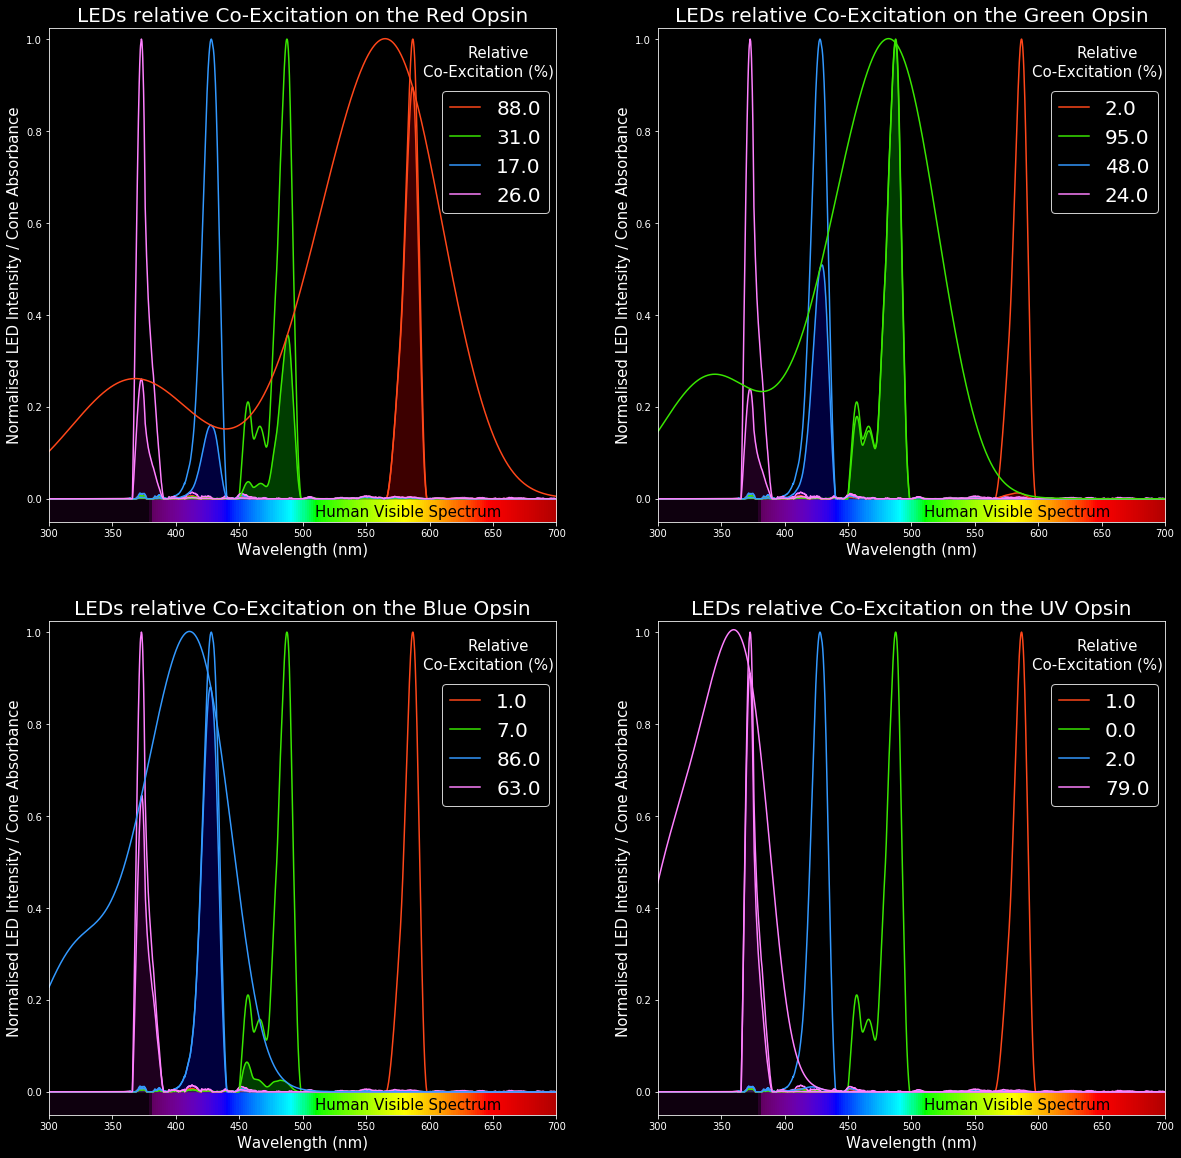

In [19]:
fig,ax = plt.subplots(2,2,figsize = (20,20))

for i in range (nLED):
    ax[0,0].plot(WvsX, LEDnormalised[i], colors[i])
ax[0,0].legend((np.around(M1_Matrix[0][0]), np.around(M1_Matrix[1][0]), np.around(M1_Matrix[2][0]), np.around(M1_Matrix[3][0])), shadow=True,loc=(0.775, 0.625), handlelength=1.5, fontsize=20)
ax[0,0].text(630,0.96, 'Relative', fontsize=15);
ax[0,0].text(595,0.92, 'Co-Excitation (%)', fontsize=15);
for i in range (nLED):
    ax[0,0].plot(WvsX, LEDnormalised[i]*Opsin[0], colors[i])
    ax[0,0].fill(WvsX, LEDnormalised[i]*Opsin[0], c=RGBA[i])
ax[0,0].plot(WvsX, Opsin[0], colors[0])
ax[0,0].set_xlim(SpectraRange)
ax[0,0].set_ylim(-0.05,1.025)
ax[0,0].imshow(X, clim=clim,  extent=extent, cmap=spectralmap, aspect = 'auto')
ax[0,0].text(510, -0.0375, 'Human Visible Spectrum', color ='black', fontsize=15)
ax[0,0].set_title('LEDs relative Co-Excitation on the Red Opsin', fontsize = 20)
ax[0,0].set_xlabel('Wavelength (nm)', fontsize = 15)
ax[0,0].set_ylabel('Normalised LED Intensity / Cone Absorbance', fontsize = 15)

for i in range (nLED):
    ax[0,1].plot(WvsX, LEDnormalised[i], colors[i])
ax[0,1].legend((np.around(M1_Matrix[0][1]), np.around(M1_Matrix[1][1]), np.around(M1_Matrix[2][1]), np.around(M1_Matrix[3][1])), shadow=True,loc=(0.775, 0.625), handlelength=1.5, fontsize=20)
ax[0,1].text(630,0.96, 'Relative', fontsize=15);
ax[0,1].text(595,0.92, 'Co-Excitation (%)', fontsize=15);
for i in range (nLED):
    ax[0,1].plot(WvsX, LEDnormalised[i]*Opsin[1], colors[i])
    ax[0,1].fill(WvsX, LEDnormalised[i]*Opsin[1], c=RGBA[i])
ax[0,1].plot(WvsX, Opsin[1], colors[1])
ax[0,1].set_xlim(SpectraRange)
ax[0,1].set_ylim(-0.05,1.025)
ax[0,1].imshow(X, clim=clim,  extent=extent, cmap=spectralmap, aspect = 'auto')
ax[0,1].text(510, -0.0375, 'Human Visible Spectrum', color ='black', fontsize=15)
ax[0,1].set_title('LEDs relative Co-Excitation on the Green Opsin', fontsize = 20)
ax[0,1].set_xlabel('Wavelength (nm)', fontsize = 15)
ax[0,1].set_ylabel('Normalised LED Intensity / Cone Absorbance', fontsize = 15)

for i in range (nLED):
    ax[1,0].plot(WvsX, LEDnormalised[i], colors[i])
ax[1,0].legend((np.around(M1_Matrix[0][2]), np.around(M1_Matrix[1][2]), np.around(M1_Matrix[2][2]), np.around(M1_Matrix[3][2])), shadow=True,loc=(0.775, 0.625), handlelength=1.5, fontsize=20)
ax[1,0].text(630,0.96, 'Relative', fontsize=15);
ax[1,0].text(595,0.92, 'Co-Excitation (%)', fontsize=15);
for i in range (nLED):
    ax[1,0].plot(WvsX, LEDnormalised[i]*Opsin[2], colors[i])
    ax[1,0].fill(WvsX, LEDnormalised[i]*Opsin[2], c=RGBA[i])
ax[1,0].plot(WvsX, Opsin[2], colors[2])
ax[1,0].set_xlim(SpectraRange)
ax[1,0].set_ylim(-0.05,1.025)
ax[1,0].imshow(X, clim=clim,  extent=extent, cmap=spectralmap, aspect = 'auto')
ax[1,0].text(510, -0.0375, 'Human Visible Spectrum', color ='black', fontsize=15)
ax[1,0].set_title('LEDs relative Co-Excitation on the Blue Opsin', fontsize = 20)
ax[1,0].set_xlabel('Wavelength (nm)', fontsize = 15)
ax[1,0].set_ylabel('Normalised LED Intensity / Cone Absorbance', fontsize = 15)

for i in range (nLED):
    ax[1,1].plot(WvsX, LEDnormalised[i], colors[i])
ax[1,1].legend((np.around(M1_Matrix[0][3]), np.around(M1_Matrix[1][3]), np.around(M1_Matrix[2][3]), np.around(M1_Matrix[3][3])), shadow=True,loc=(0.775, 0.625), handlelength=1.5, fontsize=20)
ax[1,1].text(630,0.96, 'Relative', fontsize=15);
ax[1,1].text(595,0.92, 'Co-Excitation (%)', fontsize=15);
for i in range (nLED):
    ax[1,1].plot(WvsX, LEDnormalised[i]*Opsin[3], colors[i])
    ax[1,1].fill(WvsX, LEDnormalised[i]*Opsin[3], c=RGBA[i])
ax[1,1].plot(WvsX, Opsin[3], colors[3])
ax[1,1].set_xlim(SpectraRange);
ax[1,1].set_ylim(-0.05,1.025)
ax[1,1].imshow(X, clim=clim,  extent=extent, cmap=spectralmap, aspect = 'auto')
ax[1,1].text(510, -0.0375, 'Human Visible Spectrum', color ='black', fontsize=15)  
ax[1,1].set_title('LEDs relative Co-Excitation on the UV Opsin', fontsize = 20)
ax[1,1].set_xlabel('Wavelength (nm)', fontsize = 15)
ax[1,1].set_ylabel('Normalised LED Intensity / Cone Absorbance', fontsize = 15);

fig.savefig('LED-Opsin Co-Excitation.png')

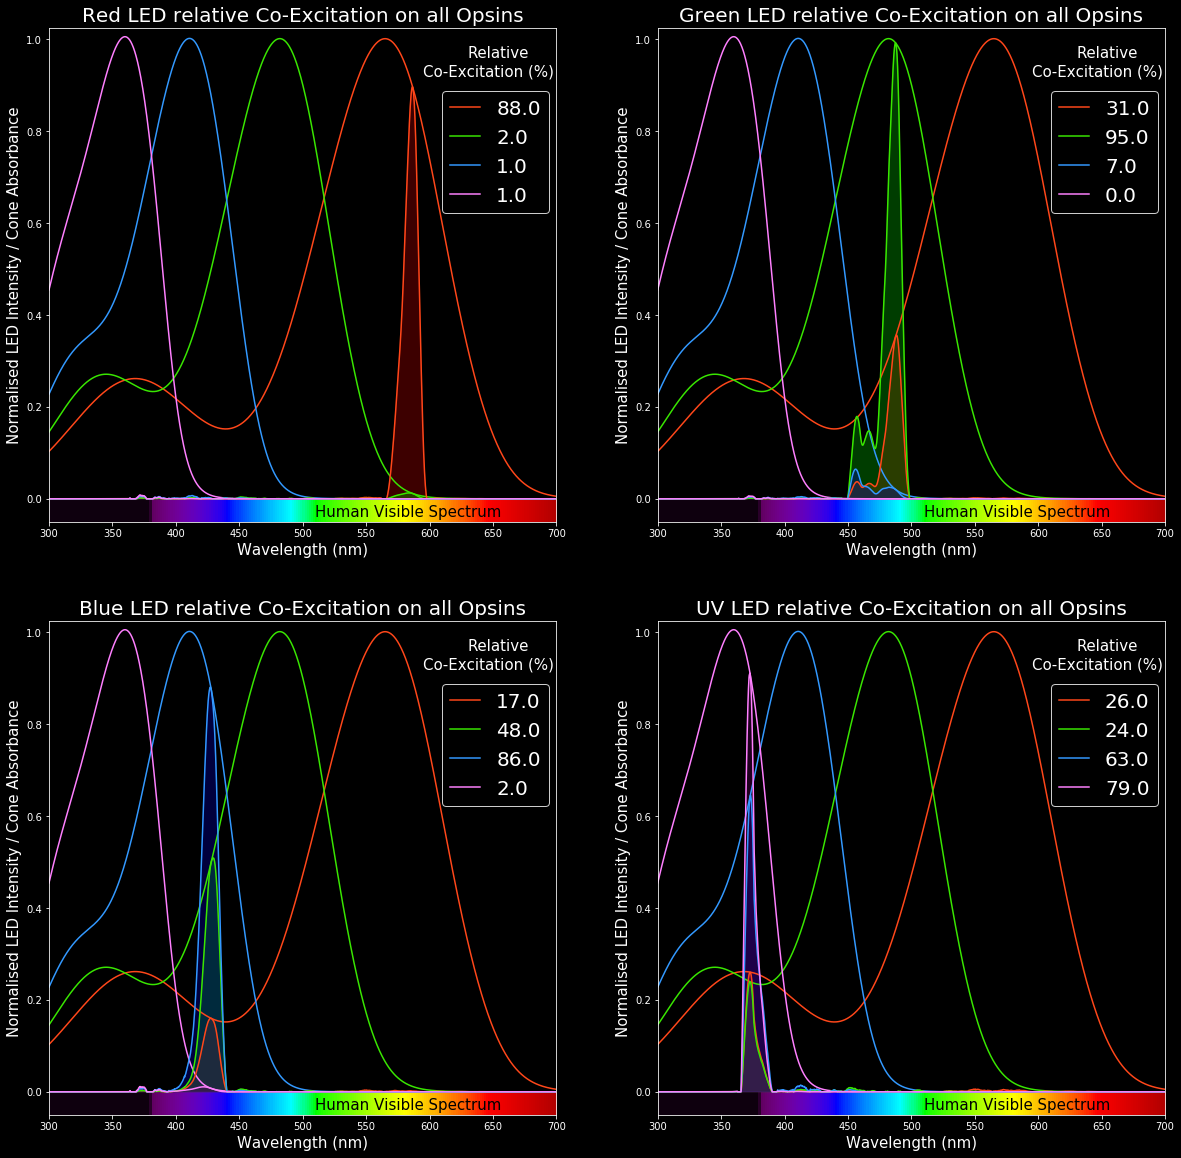

In [20]:
fig,ax = plt.subplots(2,2,figsize = (20,20))

for i in range (nCone):
    ax[0,0].plot(WvsX, Opsin[i], colors[i])
ax[0,0].legend((np.around(M1_Matrix[0][0]), np.around(M1_Matrix[0][1]), np.around(M1_Matrix[0][2]), np.around(M1_Matrix[0][3])), shadow=True,loc=(0.775, 0.625), handlelength=1.5, fontsize=20)
ax[0,0].text(630,0.96, 'Relative', fontsize=15);
ax[0,0].text(595,0.92, 'Co-Excitation (%)', fontsize=15);

for i in range (nLED):
    ax[0,0].plot(WvsX, LEDnormalised[0]*Opsin[i], colors[i])
    ax[0,0].fill(WvsX, LEDnormalised[0]*Opsin[i], c=RGBA[i])
    
ax[0,0].set_xlim(SpectraRange)
ax[0,0].set_ylim(-0.05,1.025)
ax[0,0].imshow(X, clim=clim,  extent=extent, cmap=spectralmap, aspect = 'auto')
ax[0,0].text(510, -0.0375, 'Human Visible Spectrum', color ='black', fontsize=15)
ax[0,0].set_title('Red LED relative Co-Excitation on all Opsins', fontsize = 20)
ax[0,0].set_xlabel('Wavelength (nm)', fontsize = 15)
ax[0,0].set_ylabel('Normalised LED Intensity / Cone Absorbance', fontsize = 15)


for i in range (nCone):
    ax[0,1].plot(WvsX, Opsin[i], colors[i])
ax[0,1].legend((np.around(M1_Matrix[1][0]), np.around(M1_Matrix[1][1]), np.around(M1_Matrix[1][2]), np.around(M1_Matrix[1][3])), shadow=True,loc=(0.775, 0.625), handlelength=1.5, fontsize=20)
ax[0,1].text(630,0.96, 'Relative', fontsize=15);
ax[0,1].text(595,0.92, 'Co-Excitation (%)', fontsize=15);

for i in range (nLED):
    ax[0,1].plot(WvsX, LEDnormalised[1]*Opsin[i], colors[i])
    ax[0,1].fill(WvsX, LEDnormalised[1]*Opsin[i], c=RGBA[i])
    
ax[0,1].set_xlim(SpectraRange)
ax[0,1].set_ylim(-0.05,1.025)
ax[0,1].imshow(X, clim=clim,  extent=extent, cmap=spectralmap, aspect = 'auto')
ax[0,1].text(510, -0.0375, 'Human Visible Spectrum', color ='black', fontsize=15)
ax[0,1].set_title('Green LED relative Co-Excitation on all Opsins', fontsize = 20)
ax[0,1].set_xlabel('Wavelength (nm)', fontsize = 15)
ax[0,1].set_ylabel('Normalised LED Intensity / Cone Absorbance', fontsize = 15)


for i in range (nCone):
    ax[1,0].plot(WvsX, Opsin[i], colors[i])
ax[1,0].legend((np.around(M1_Matrix[2][0]), np.around(M1_Matrix[2][1]), np.around(M1_Matrix[2][2]), np.around(M1_Matrix[2][3])), shadow=True,loc=(0.775, 0.625), handlelength=1.5, fontsize=20)
ax[1,0].text(630,0.96, 'Relative', fontsize=15);
ax[1,0].text(595,0.92, 'Co-Excitation (%)', fontsize=15);

for i in range (nLED):
    ax[1,0].plot(WvsX, LEDnormalised[2]*Opsin[i], colors[i])
    ax[1,0].fill(WvsX, LEDnormalised[2]*Opsin[i], c=RGBA[i])
    
ax[1,0].set_xlim(SpectraRange)
ax[1,0].set_ylim(-0.05,1.025)
ax[1,0].imshow(X, clim=clim,  extent=extent, cmap=spectralmap, aspect = 'auto')
ax[1,0].text(510, -0.0375, 'Human Visible Spectrum', color ='black', fontsize=15)
ax[1,0].set_title('Blue LED relative Co-Excitation on all Opsins', fontsize = 20)
ax[1,0].set_xlabel('Wavelength (nm)', fontsize = 15)
ax[1,0].set_ylabel('Normalised LED Intensity / Cone Absorbance', fontsize = 15)


for i in range (nCone):
    ax[1,1].plot(WvsX, Opsin[i], colors[i])
ax[1,1].legend((np.around(M1_Matrix[3][0]), np.around(M1_Matrix[3][1]), np.around(M1_Matrix[3][2]), np.around(M1_Matrix[3][3])), shadow=True,loc=(0.775, 0.625), handlelength=1.5, fontsize=20)
ax[1,1].text(630,0.96, 'Relative', fontsize=15);
ax[1,1].text(595,0.92, 'Co-Excitation (%)', fontsize=15);

for i in range (nLED):
    ax[1,1].plot(WvsX, LEDnormalised[3]*Opsin[i], colors[i])
    ax[1,1].fill(WvsX, LEDnormalised[3]*Opsin[i], c=RGBA[i])
    
ax[1,1].set_xlim(SpectraRange)
ax[1,1].set_ylim(-0.05,1.025)
ax[1,1].imshow(X, clim=clim,  extent=extent, cmap=spectralmap, aspect = 'auto')
ax[1,1].text(510, -0.0375, 'Human Visible Spectrum', color ='black', fontsize=15)
ax[1,1].set_title('UV LED relative Co-Excitation on all Opsins', fontsize = 20)
ax[1,1].set_xlabel('Wavelength (nm)', fontsize = 15)
ax[1,1].set_ylabel('Normalised LED Intensity / Cone Absorbance', fontsize = 15);


fig.savefig('Opsin-LED Co-Excitation.png')

***

# Extract Powermeter Recording to determine the electrical power (in nW)
Here, we used an optical energy power (PM100D, Thorlabs, Germany) in combination with the Thorlabs Optical Power Monitor (OPM) software and coupled to a photodiode power sensor (S130VC, Thorlabs, Germany).

The following script is configured by default for ThorLab Powermeter recording in .csv format. If a different spectrometer is used, the general parameters below need to be modified

In [21]:
r_sensor_um = (9.5/2)*1000                              # Set the sensor radius in micrometer 
SensorArea = np.pi*(r_sensor_um**2)                     # Calculate the sensor area

Steps = 101                                             # Set the number of recording points for each LED
Red_FirstRecording = 25                                 # Set for the Red recording the first recording point
Red_LastRecording = Red_FirstRecording + Steps
Green_FirstRecording = 23                               # Set for the Green recording the first recording point
Green_LastRecording = Green_FirstRecording + Steps
Blue_FirstRecording = 23                                # Set for the Blue recording the first recording point
Blue_LastRecording = Blue_FirstRecording + Steps
UV_FirstRecording = 22                                  # Set for the UV recording the first recording point
UV_LastRecording = UV_FirstRecording + Steps

Red_FileName = powerPath + 'Red.csv'                    # Import the Red recording (Red.csv has to be the name of the recording csv file)
Green_FileName = powerPath + 'Green.csv'                # Import the Green recording (Red.csv has to be the name of the recording csv file)
Blue_FileName = powerPath + 'Blue.csv'                  # Import the Blue recording (Red.csv has to be the name of the recording csv file)
UV_FileName = powerPath + 'UV.csv'                      # Import the UV recording (Red.csv has to be the name of the recording csv file)

## Plot Energy readings for each LED 

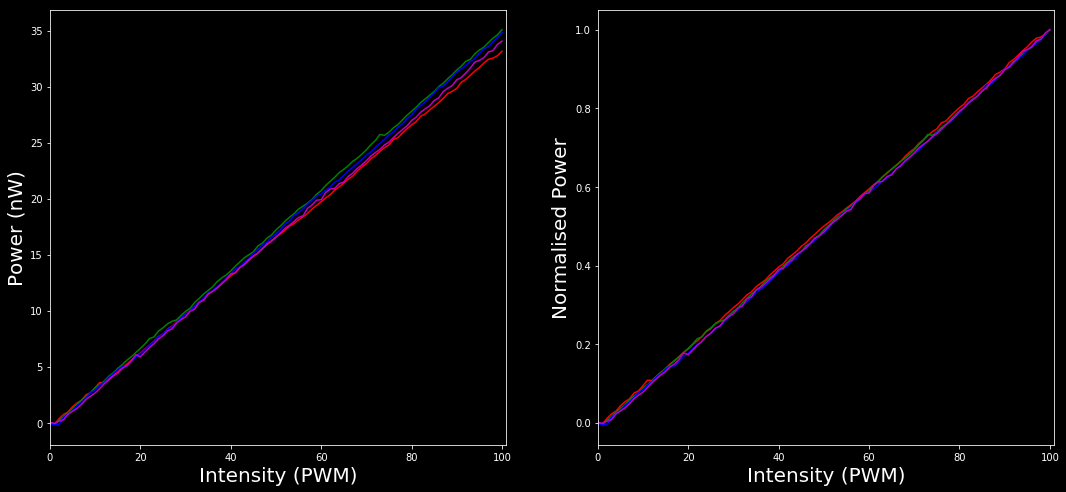

In [22]:
powermeter_red = pd.read_csv(Red_FileName, sep = ';',skiprows = Red_FirstRecording, header = None, names = ['number','time','power','irradiance','current','saturation','power(dbm)'])
Power_red = np.asarray(powermeter_red.power)[:Steps]*10**9
Irradiance_red = np.asarray(powermeter_red.irradiance)[:Steps]*10

powermeter_green = pd.read_csv(Green_FileName, sep = ';',skiprows = Green_FirstRecording, header = None, names = ['number','time','power','irradiance','current','saturation','power(dbm)'])
Power_green = np.asarray(powermeter_green.power)[:Steps]*10**9
Irradiance_green = np.asarray(powermeter_green.irradiance)[:Steps]*10

powermeter_blue= pd.read_csv(Blue_FileName, sep = ';',skiprows = Blue_FirstRecording, header = None, names = ['number','time','power','irradiance','current','saturation','power(dbm)'])
Power_blue = np.asarray(powermeter_blue.power)[:Steps]*10**9
Irradiance_blue = np.asarray(powermeter_blue.irradiance)[:Steps]*10

powermeter_uv = pd.read_csv(UV_FileName, sep = ';',skiprows = UV_FirstRecording, header = None, names = ['number','time','power','irradiance','current','saturation','power(dbm)'])
Power_uv = np.asarray(powermeter_uv.power)[:Steps]*10**9
Irradiance_uv = np.asarray(powermeter_uv.irradiance)[:Steps]*10

norm_power_red = normalise(Power_red)
norm_power_green = normalise(Power_green)
norm_power_blue = normalise(Power_blue)
norm_power_uv = normalise(Power_uv)

norm_irradiance_red = normalise(Irradiance_red)
norm_irradiance_green = normalise(Irradiance_green)
norm_irradiance_blue = normalise(Irradiance_blue)
norm_irradiance_uv = normalise(Irradiance_uv)

Power = np.zeros((nLED,Steps))
Power = (Power_red,Power_green,Power_blue,Power_uv)

Norm_Power = np.zeros((nLED,Steps))
Norm_Power = (norm_power_red,norm_power_green,norm_power_blue,norm_power_uv)

Irradiance = np.zeros((nLED,Steps))
Irradiance = (Irradiance_red,Irradiance_green,Irradiance_blue,Irradiance_uv)

Norm_Irradiance = np.zeros((nLED,Steps))
Norm_Irradiance = (norm_irradiance_red,norm_irradiance_green,norm_irradiance_blue,norm_irradiance_uv)

y_Steps = np.arange(0,Steps,1)
fig,ax = plt.subplots(1,2,figsize = (18,8))

for iLED in range (nLED):
    ax[0].plot(y_Steps,Power[iLED],c=colour[iLED])
    ax[1].plot(y_Steps,Norm_Power[iLED],c=colour[iLED])

ax[0].set_xlabel('Intensity (PWM)', fontsize = FigureFontSize)
ax[0].set_ylabel('Power (nW)', fontsize = FigureFontSize)
ax[0].set_xlim(0,101);

ax[1].set_xlabel('Intensity (PWM)', fontsize = FigureFontSize)
ax[1].set_ylabel('Normalised Power', fontsize = FigureFontSize);
ax[1].set_xlim(0,101);

fig.savefig('Powermeter Recordings.png')

# Determine Photo-Isomerisation Rates for all LED and Photoreceptor combinations

## Photoisomerisation rate = $\Sigma R_{Ph}(\lambda) . S_{Act}(\lambda)$

### Where the Photon Flux $R_{Ph}(\lambda) = P_{E}(\lambda) . A_{collect}$

### And the Specific Activation $S_{Act}(\lambda) = S_{opsin}.S_{LED}$

With:

$P_{E}(\lambda)$ the specific photon flux density

$A_{collect}$ the light collection area of cone outer segments

$S_{opsin}$ the opsin sensitivity spectra

$S_{LED}$ the LED peak-normalised spectra


***

### Determining the photon density flux density $P_{E}(\lambda)$ for each LED

#### Calculate the wavelength-dependent photon energy Q in $eV$

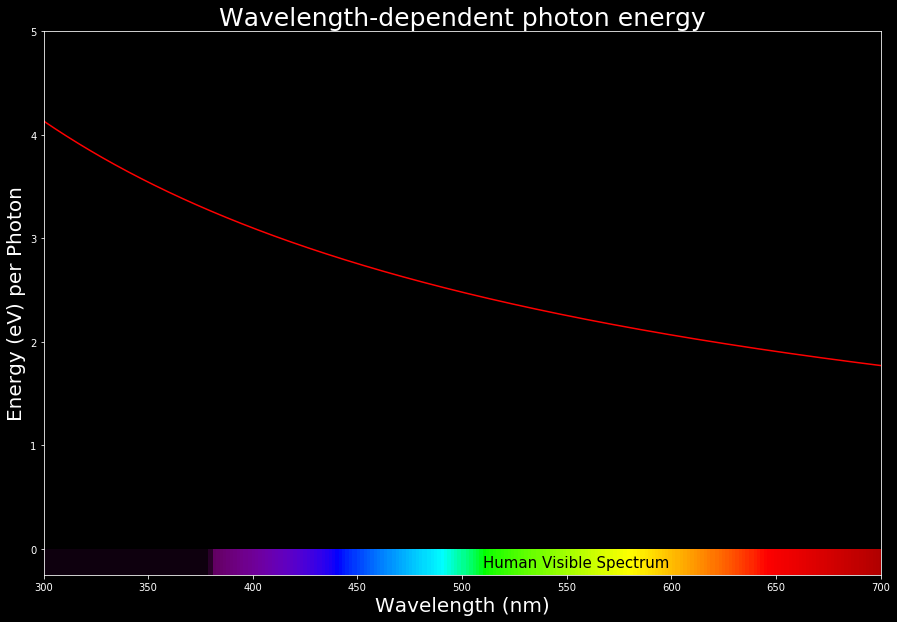

In [23]:
h = 4.135667E-15                         # Planck's constant [eV*s]
c = 299792458                            # Speed of light [m/s]

Power_Q = np.array((c*h/(WvsX *1E-9)), dtype=float)


fig,ax = plt.subplots(1,1,figsize = FigureSize)
ax.plot(WvsX, Power_Q, color ='r')

ax.set_title('Wavelength-dependent photon energy', fontsize = FigureTitleSize)
plt.xlabel('Wavelength (nm)', fontsize = FigureFontSize)
plt.ylabel('Energy (eV) per Photon', fontsize = FigureFontSize)

ax.imshow(X, clim=clim,  extent=extent, cmap=spectralmap, aspect = 'auto')
plt.text(510, -0.175, 'Human Visible Spectrum', color ='black', fontsize=15)

ax.set_xlim(SpectraRange)
ax.set_ylim(-0.25,5);

#### Convert Energy Flux from $nW$ into $eV . s^{-1}$ for each LED recording

In [24]:
eV_per_J = 6.242E+18    # [eV] per [J]

Pow_eFlux = np.zeros((nLED,Steps))
for iLED in range (nLED):
    Pow_eFlux[iLED,:] = np.multiply(Power[iLED]*10**-9,eV_per_J)
    
Irr_eFlux = np.zeros((nLED,Steps))
for iLED in range (nLED):
    Irr_eFlux[iLED,:] = np.multiply(Irradiance[iLED]*10**-9,eV_per_J)
    

#### Report for each LED, the Energy Flux mesured at max intensity (PWM = 255) to the normalised LED spectra integrals  


In [25]:
Power_eFlux = np.zeros((nLED,len(WvsX)))
LEDint = np.zeros((nLED))
normLED = np.zeros((nLED,len(WvsX)))

for iLED in range (nLED):
    
    LEDint[:] = np.sum(LEDnormalised[iLED])

    normLED[iLED] = np.divide(LEDnormalised[iLED],LEDint[iLED])

    Power_eFlux[iLED,:] = np.multiply(Pow_eFlux[iLED,-1],normLED[iLED,:])

    
Irradiance_eFlux = np.zeros((nLED,len(WvsX)))

for iLED in range (nLED):
    Irradiance_eFlux[iLED,:] = np.multiply(Irr_eFlux[iLED,-1],normLED[iLED,:])

#### Divide Energy Flux by the Photon Energy to get the Photon Flux $\phi$ ($photons . s^{-1} $) 

In [26]:
Power_Phi = np.zeros((nLED,len(WvsX)))
for iLED in range (nLED):
    Power_Phi[iLED] = np.divide(Power_eFlux[iLED],Power_Q)
    
Irradiance_Phi = np.zeros((nLED,len(WvsX)))
for iLED in range (nLED):
    Irradiance_Phi[iLED] = np.divide(Irradiance_eFlux[iLED],Power_Q)

#### Finally determine Photon Flux Density $P_{E}(\lambda)$ ($photons . s^{-1} . µm^{-2}$)

In [27]:
Power_E = np.zeros((nLED,len(WvsX)))
for iLED in range (nLED):
    Power_E[iLED] = np.divide(Power_Phi[iLED],SensorArea)
    
Irradiance_E = Irradiance_Phi

#### Determine the Photon Flux Density per LED from the Irradiance Recording

In [28]:
IntIrradiance_E = np.zeros((nLED))
for iLED in range(nLED):
    IntIrradiance_E[iLED] = np.sum(Irradiance_E[iLED])
    
print('Red LED = ' + str(IntIrradiance_E[0]) + ' photon/s/µ𝑚2')
print('Green LED = ' + str(IntIrradiance_E[1]) + ' photon/s/µ𝑚2')
print('Blue LED = ' + str(IntIrradiance_E[2]) + ' photon/s/µ𝑚2')
print('UV LED = ' + str(IntIrradiance_E[3]) + ' photon/s/µ𝑚2')

Red LED = 328.35378979566343 photon/s/µ𝑚2
Green LED = 231.781567534848 photon/s/µ𝑚2
Blue LED = 165.69143595430035 photon/s/µ𝑚2
UV LED = 117.16662119887987 photon/s/µ𝑚2


## Determining the Light Collection Area of cone outer segments

 ### $A_{collect} = OSA . \gamma . 1-10^{\alpha . OSL}$

With

OSA the Outer Segment Area

$\gamma$ the quantum efficiency of the opsin change

$\alpha$ the cone specific absorption coefficient 

OSL the Outer Segment Length

#### Set Cones physiological features

In [29]:
# Outer Segment Diameter for R,G,B & UV cones in µm. 
# Allison et al. 2004 - Visual pigment composition in zebrafish
OSD = np.asarray([2.4, 2.4, 2.8, 2.6], dtype = np.float64) 

# Outer Segment Area
OSA = np.pi*(OSD[:]/2)**2

# Outer Segment Length in µm 
# Branchek et al. 1984 - The development of photoreceptors in the zebrafish, Brachydanio rerio. I. Structure 
OSL = [10, 10, 7.6, 10]

# Specific Absorbance for R,G,B & UV opsins in µm-1
# Allison et al. 2004 - Visual pigment composition in zebrafish
Alpha = [0.0073, 0.0063, 0.007, 0.0054] 

# Quantum efficiency of the opsin change (p(Photoisomerisation/Light being absorbed)) 
# Dartnall et al. 1967 - The photosensitivities of visual pigments in the presence of hydroxylamine
Gamma = 0.67 

#### Determine the Specific Absorption Coefficient $1-10^{\alpha . OSL}$ 

Also known as the Specific Optical Density, it is defined as the fraction of light absorbed per infinitesimal unit length of photopigment. It depends only on the absorption properties of the photopigment.

In [30]:
Absorption_coef = np.zeros((nCone))
for iCone in range (nCone):
    Absorption_coef[iCone] = 1-(10**(-Alpha[iCone]*OSL[iCone]))

#### Determine the Light Collection Area $A_{collect}$ = OSA . $\gamma$ . Absorption Coefficient

In [31]:
A_Collect = np.zeros((nCone))
for iCone in range (nCone):
    A_Collect[iCone] = OSA[iCone] * Gamma * Absorption_coef[iCone] 

***

### Finally, determine the Photo-isomerisation state for each opsin and LED combinations

C:\Users\Maxime\Anaconda3\lib\site-packages\ipykernel_launcher.py:65: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


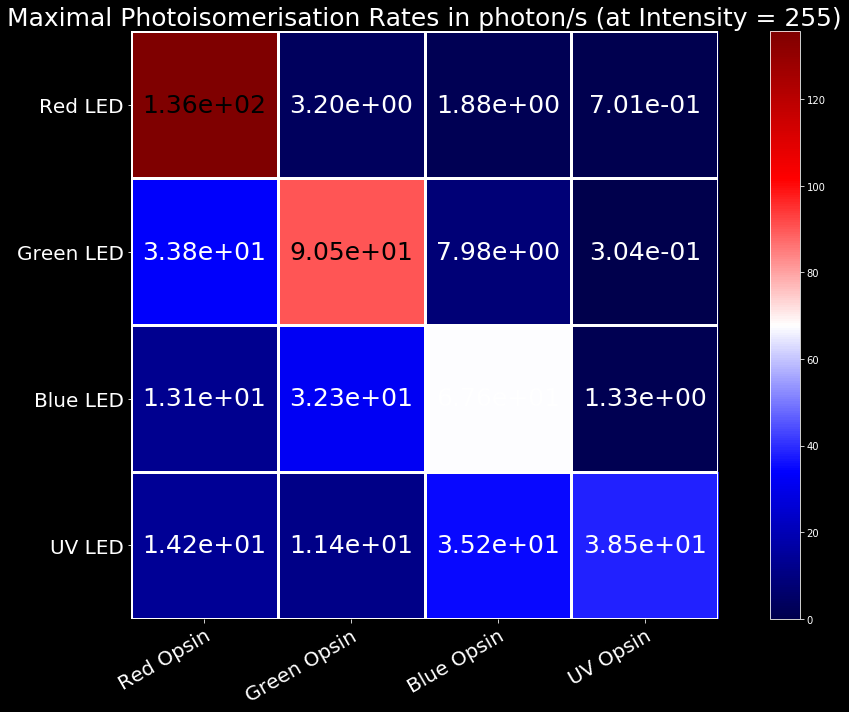

In [32]:
M1_Isomerisation = np.zeros((nCone,nLED))
for iCone in range(nCone):              # For each cone...
    for iLED in range(nLED):               # For each LED...
        M1_Isomerisation[iCone,iLED] = M1[iCone,iLED] * IntIrradiance_E[iLED] * A_Collect[iCone]

M1_Isomerisation = M1_Isomerisation.swapaxes(1,0)
vmaxMiso = np.amax(np.abs(M1_Isomerisation.reshape(-1)))
vminMiso = 0   
fig, (ax) = plt.subplots(1, 1, figsize=FigureSize)
im, _ = heatmap(M1_Isomerisation, LEDs, Cones, ax=ax, cmap=colourmap, vmax = vmaxMiso, vmin = vminMiso)
annotate_heatmap(im, valfmt="{x:.2e}", size=FigureFontSize+5)
ax.set_title('Maximal Photoisomerisation Rates in photon/s (at Intensity = 255)', fontsize = FigureTitleSize)
fig.tight_layout()

fig.savefig('Photo-Isomerisation Rates Matrix.png');

C:\Users\Maxime\Anaconda3\lib\site-packages\ipykernel_launcher.py:65: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


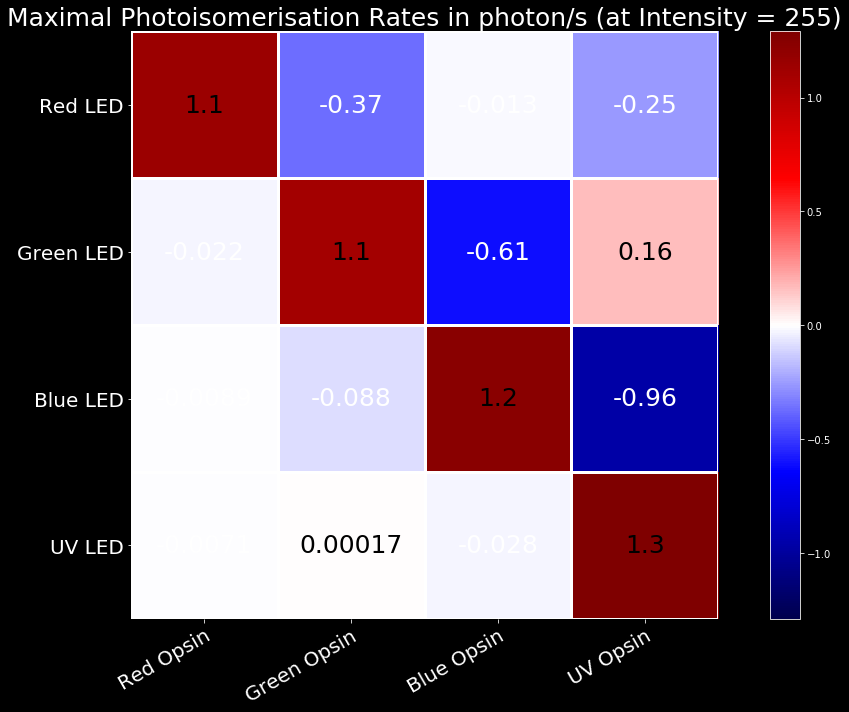

In [33]:
N1 = np.linalg.inv(M1)                    # Inverse of M1 

vmaxN1 = np.amax(np.abs(N1.reshape(-1)))
vminN1 = -vmaxN1   
fig, (ax) = plt.subplots(1, 1, figsize=FigureSize)
im, _ = heatmap(N1, LEDs, Cones, ax=ax, cmap=colourmap, vmax = vmaxN1, vmin = vminN1)
annotate_heatmap(im, valfmt="{x:.2}", size=FigureFontSize+5)
ax.set_title('Maximal Photoisomerisation Rates in photon/s (at Intensity = 255)', fontsize = FigureTitleSize)
fig.tight_layout()